## Moondream2 Float16

In [1]:
import time
import cv2

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image, ImageDraw

### Check List of Models

In [2]:
from huggingface_hub import list_models

# List models by user "vikhyatk"
models_user = list_models(author="vikhyatk")
print("Models by vikhyatk:")
for m in models_user:
    print("-", m.modelId)

# List models under org "moondream"
models_org = list_models(author="moondream")
print("\nModels under 'moondream' org:")
for m in models_org:
    print("-", m.modelId)

Models by vikhyatk:
- vikhyatk/moondream2
- vikhyatk/moondream0
- vikhyatk/moondream1
- vikhyatk/moondream-next
- vikhyatk/textvqa_val
- vikhyatk/mystery-ckpts

Models under 'moondream' org:
- moondream/moondream2-gguf
- moondream/ft-detect-skus-coreml
- moondream/moondream-2b-2025-04-14
- moondream/starmie-v1
- moondream/moondream-2b-2025-04-14-4bit


In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "moondream/moondream-2b-2025-04-14",
    # revision="2025-06-21",
    trust_remote_code=True,
    device_map="auto", 
)

In [5]:
dtype = next(model.parameters()).dtype
print(dtype)

torch.float16


In [6]:
print(model)

HfMoondream(
  (model): MoondreamModel(
    (vision): ModuleDict(
      (patch_emb): Linear(in_features=588, out_features=1152, bias=True)
      (blocks): ModuleList(
        (0-26): 27 x ModuleDict(
          (ln1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (attn): ModuleDict(
            (qkv): Linear(in_features=1152, out_features=3456, bias=True)
            (proj): Linear(in_features=1152, out_features=1152, bias=True)
          )
          (ln2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
          (mlp): ModuleDict(
            (fc1): Linear(in_features=1152, out_features=4304, bias=True)
            (fc2): Linear(in_features=4304, out_features=1152, bias=True)
          )
        )
      )
      (post_ln): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
      (proj_mlp): ModuleDict(
        (fc1): Linear(in_features=2304, out_features=8192, bias=True)
        (fc2): Linear(in_features=8192, out_features=2048, bias=True)
      )
    )
  

### 1. Short Caption

In [7]:
img = Image.open("../tasks/bird.jpg")
print('Short caption:')
t1 = time.time()
print(model.caption(img, length="short")["caption"])
t2 = time.time()
diff = t2 - t1
print(f"Total time taken : {round(diff,2)}")

Short caption:
 A hummingbird hovers near a vibrant red and orange flower, with a blurred background emphasizing the bird's flight.
Total time taken : 4.17


### 2. Normal Caption

In [8]:
print('Normal caption:')
t1 = time.time()
normal_caption = model.caption(img, length="normal")["caption"]

for t in normal_caption:
    print(t, end="", flush=True)
t2 = time.time()
diff = t2 - t1
print(f"\Caption Time : {round(diff,2)}")

Normal caption:
 A hummingbird with a green and gray body and a long, slender beak is captured in mid-flight, hovering near a vibrant red flower. The flower, with its numerous small, orange petals, is attached to a green stem. The background is a soft, out-of-focus yellowish-beige, providing a contrast to the vivid colors of the flower and hummingbird. Another red flower is partially visible in the bottom left corner of the image.\Caption Time : 8.14


### 3. Long Caption

In [9]:
print('Long caption:')
t1 = time.time()
long_caption = model.caption(img, length="long")["caption"]

for t in long_caption:
    print(t, end="", flush=True)
    
t2 = time.time()
diff = t2 - t1
print(f"\nCaption Time : {round(diff,2)}")

Long caption:
 The image captures a vibrant scene of nature, featuring a hummingbird in mid-flight near a striking red and orange flower. The hummingbird, with its slender, long beak, is in sharp focus, showcasing its detailed features and graceful wings. Its body is covered in a mix of grey and green feathers, blending harmoniously with the flower's colors. The hummingbird appears to be hovering near the flower, possibly feeding on its nectar.

The flower, prominently positioned in the center of the image, is a unique and captivating sight. It has a slender, elongated stem covered in delicate, elongated petals in a striking combination of red and orange. The petals are arranged in a circular pattern, creating a visually appealing and symmetrical appearance. Some petals are slightly curled or folded, adding texture and depth to the flower's structure.

In the background, slightly blurred, is another flower, also with red and orange petals, positioned to the left side of the image. This

### 4. VQA using MoonDream - Example 1

In [10]:
# Visual Querying
qimg = Image.open('../tasks/potholes.png')
print("\nVisual query: 'How many potholes are there in the image?'")
print(model.query(qimg, "How many potholes are there in the image?")["answer"])


Visual query: 'How many potholes are there in the image?'
 There is one pothole in the image.


### 5. VQA using MoonDream - Example 2

In [11]:
# Visual Querying
qimg = Image.open('../tasks/cable-trip.jpg')
print("\nVisual query: 'Why is the person falling?'")
print(model.query(qimg, "Why is the person falling?")["answer"])


Visual query: 'Why is the person falling?'
 The person is falling because they have tripped over a yellow extension cord on the floor. The cord is tangled and lies on the ground, causing the person to lose their balance and fall. This incident highlights the importance of being cautious and aware of one's surroundings, especially in industrial or commercial environments where electrical cords and equipment are present.


### 6. Object Detection

In [12]:
# Object Detection
imgf = Image.open('../tasks/driving-gaze.jpg')
print("\nObject detection: 'face'")
objects = model.detect(imgf, "face")["objects"]
print(f"Found {len(objects)} face(s)")
w, h = imgf.size


Object detection: 'face'
Found 1 face(s)


In [13]:
for bbox in objects:
    # Convert normalized to pixel coords
    x_min = int(bbox['x_min'] * w)
    y_min = int(bbox['y_min'] * h)
    x_max = int(bbox['x_max'] * w)
    y_max = int(bbox['y_max'] * h)

print(x_min)

173


Text(0.5, 1.0, 'Face Detected')

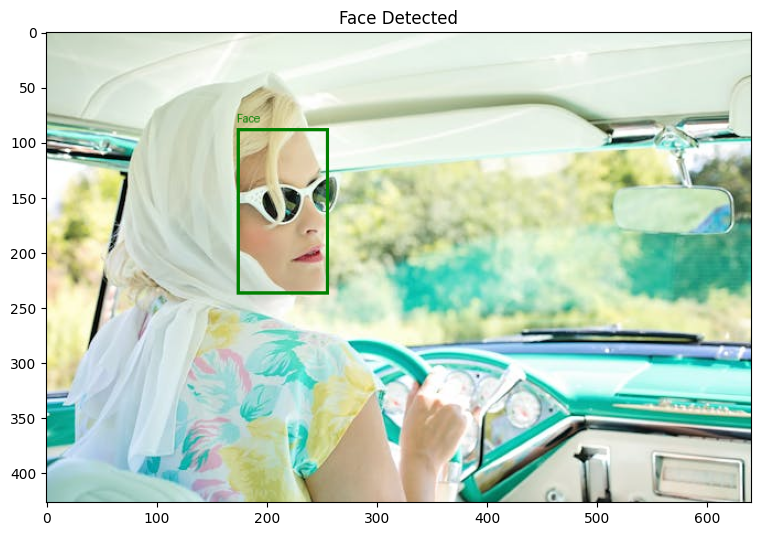

In [14]:
# Create draw object
draw = ImageDraw.Draw(imgf)
# Loop over bboxes
for bbox in objects:
    # Convert normalized to pixel coords
    x_min = int(bbox['x_min'] * w)
    y_min = int(bbox['y_min'] * h)
    x_max = int(bbox['x_max'] * w)
    y_max = int(bbox['y_max'] * h)

    # Draw rectangle (outline only)
    draw.rectangle([x_min, y_min, x_max, y_max], outline="green", width=3)

    # Optionally add text
    draw.text((x_min, y_min - 15), "Face", fill="green")

plt.figure(figsize = [20, 8])
plt.subplot(121); plt.imshow(imgf); plt.title('Face Detected')

### 7. Pointing

In [16]:
# Pointing
imgf = Image.open('../tasks/driving-gaze.jpg')
print("\nPointing: 'person'")
points = model.point(imgf, "person")["points"]
print(f"Found {len(points)} person(s)")


Pointing: 'person'
Found 1 person(s)


In [17]:
points

[{'x': 0.3056640625, 'y': 0.7568359375}]

In [15]:
import torch
from transformers import AutoTokenizer, AutoModel
path = "OpenGVLab/InternVL3_5-8B"
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    load_in_8bit=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval()


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [2]:
!pip install einops timm

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 64.4/64.4 KB 791.6 kB/s eta 0:00:00a 0:00:01
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.5/2.5 MB 5.4 MB/s eta 0:00:0000:0100:01


In [6]:
!pip install -U bitsandbytes

In [9]:
!git clone https://github.com/TimDettmers/bitsandbytes.git
%cd bitsandbytes

Cloning into 'bitsandbytes'...
remote: Enumerating objects: 10797, done.
remote: Counting objects: 100% (477/477), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 10797 (delta 385), reused 263 (delta 263), pack-reused 10320 (from 4)
Receiving objects: 100% (10797/10797), 3.48 MiB | 1.46 MiB/s, done.
Resolving deltas: 100% (7265/7265), done.
/home/opencv/vlm-bench/hface/bitsandbytes


/home/opencv/kukil/vlm/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
!pip install pickleshare

In [19]:
!python setup.py install

/home/opencv/vlm-bench/hface/bitsandbytes/setup.py:5: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.errors import DistutilsModuleError
/usr/lib/python3.10/distutils/dist.py:274: UserWarning: Unknown distribution option: 'cmake_source_dir'
  warnings.warn(msg)
running install
/home/opencv/kukil/vlm/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/opencv/kukil/vlm/lib/python3.10/site-packages/setuptools/command/easy_install.py:158: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing UNKNOWN.egg-info/PKG-INFO
writing dependency_links to UNKNOWN.egg-info/dependency_links.txt
writing top-level nam

In [16]:
!pip list

Package                   Version
------------------------- --------------
accelerate                1.10.1
annotated-types           0.7.0
anyio                     4.10.0
argon2-cffi               25.1.0
argon2-cffi-bindings      25.1.0
arrow                     1.3.0
asttokens                 3.0.0
async-lru                 2.0.5
attrs                     25.3.0
babel                     2.17.0
beautifulsoup4            4.13.5
bitsandbytes              0.47.0
bleach                    6.2.0
certifi                   2025.8.3
cffi                      1.17.1
charset-normalizer        3.4.3
comm                      0.2.3
contourpy                 1.3.2
cycler                    0.12.1
debugpy                   1.8.16
decorator                 5.2.1
defusedxml                0.7.1
distro                    1.9.0
einops                    0.8.1
exceptiongroup            1.3.0
executing                 2.2.1
fastjsonschema            2.21.2
filelock                  3.19.1
fonttools    

In [18]:
!pip uninstall bitsandbytes -y

Found existing installation: bitsandbytes 0.47.0
Uninstalling bitsandbytes-0.47.0:
  Successfully uninstalled bitsandbytes-0.47.0


In [21]:
!python -m bitsandbytes

bitsandbytes library load error: Configured CUDA binary not found at /home/opencv/vlm-bench/hface/bitsandbytes/bitsandbytes/libbitsandbytes_cuda126.so
 If you are using Intel CPU/XPU, please install intel_extension_for_pytorch to enable required ops
Traceback (most recent call last):
  File "/home/opencv/vlm-bench/hface/bitsandbytes/bitsandbytes/cextension.py", line 318, in <module>
    lib = get_native_library()
  File "/home/opencv/vlm-bench/hface/bitsandbytes/bitsandbytes/cextension.py", line 282, in get_native_library
    raise RuntimeError(f"Configured {BNB_BACKEND} binary not found at {cuda_binary_path}")
RuntimeError: Configured CUDA binary not found at /home/opencv/vlm-bench/hface/bitsandbytes/bitsandbytes/libbitsandbytes_cuda126.so
================ bitsandbytes v0.48.0.dev0 =================
Platform: Linux-5.15.148-tegra-aarch64-with-glibc2.35
  libc: glibc-2.35
Python: 3.10.12
PyTorch: 2.8.0
  CUDA: 12.6
  HIP: N/A
  XPU: N/A
Related packages:
  accelerate: 1.10.1
  diffuser